In [130]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [131]:
# Step 2: Load and Preprocess Data

def load_imdb_data():
    nltk.download('movie_reviews')
    from nltk.corpus import movie_reviews
    
    # Extracting movie reviews and their labels
    documents = [(list(movie_reviews.words(fileid)), category)
                 for category in movie_reviews.categories()
                 for fileid in movie_reviews.fileids(category)]
    
    # Convert to dataframe
    df = pd.DataFrame(documents, columns=['review', 'sentiment'])
    df['review'] = df['review'].apply(lambda x: ' '.join(x))  # Convert word lists to full text
    return df

# Preprocess the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f'[{string.punctuation}]', '', text)  # Remove punctuation
    text = re.sub('\d+', '', text)  # Remove numbers
    return text

# Load and preprocess data
df = load_imdb_data()
df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [132]:
# Step 3: Convert Text to Numerical Features

# Convert text data into numerical features using TF-IDF 
vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(df['review']) 

***Step 4: Clustering Algorithms***

In [133]:
# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
df['KMeans_Cluster'] = kmeans_labels

In [134]:
# Hierarchical Clustering
# 'ward' linkage
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_cluster_ward = agglo.fit_predict(X.toarray())
df['agg_cluster_ward'] = agg_cluster_ward 

# 'average' linkage
agg_cluster_avg = AgglomerativeClustering(n_clusters=2, linkage='average')
agg_cluster_avg = agg_cluster_avg.fit_predict(X.toarray())
df['agg_cluster_avg'] = agg_cluster_avg

# 'complete' linkage
agg_cluster_comp = AgglomerativeClustering(n_clusters=2, linkage='complete')
agg_cluster_comp = agg_cluster_comp.fit_predict(X.toarray())
df['agg_cluster_comp'] = agg_cluster_comp

In [135]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.3, min_samples=2)
dbscan_labels = dbscan.fit_predict(X)
df['DBSCAN_Cluster'] = dbscan_labels

***Step 5: Evaluation Metrics***

In [136]:
print("KMeans Silhouette Score:", silhouette_score(X, kmeans_labels))
print("Agglomerative Silhouette Score 'ward-linkage':", silhouette_score(X, agg_cluster_ward))
print("Agglomerative Silhouette Score 'average-linkage':", silhouette_score(X, agg_cluster_avg))
print("Agglomerative Silhouette Score 'complete-linkage':", silhouette_score(X, agg_cluster_comp))

dbscan_core_mask = dbscan_labels != -1
if len(set(dbscan_labels)) > 1:
    print("DBSCAN Silhouette Score:", silhouette_score(X[dbscan_core_mask], dbscan_labels[dbscan_core_mask]))
else:
    print("DBSCAN failed to form valid clusters")

KMeans Silhouette Score: 0.025063991201521803
Agglomerative Silhouette Score 'ward-linkage': -0.0077568643615814606
Agglomerative Silhouette Score 'average-linkage': 0.11735547586914255
Agglomerative Silhouette Score 'complete-linkage': 0.11431321175161567
DBSCAN Silhouette Score: 0.9434857099395385


In [137]:
number_of_noise = np.sum(dbscan_labels == -1)
print("Number of noise points (outliers):", number_of_noise)

Number of noise points (outliers): 1984


In [138]:
%time kmeans.fit_predict(X)
%time agglo.fit_predict(X.toarray())
%time dbscan.fit_predict(X)

CPU times: total: 15.6 ms
Wall time: 18.6 ms
CPU times: total: 4.47 s
Wall time: 4.62 s
CPU times: total: 594 ms
Wall time: 566 ms


array([-1, -1, -1, ..., -1, -1, -1], shape=(2000,))

In [139]:
print(df[[ 'KMeans_Cluster', 'agg_cluster_ward', 'agg_cluster_avg', 'agg_cluster_comp', 'DBSCAN_Cluster']])

      KMeans_Cluster  agg_cluster_ward  agg_cluster_avg  agg_cluster_comp  \
0                  1                 1                0                 1   
1                  1                 1                0                 1   
2                  1                 1                0                 1   
3                  1                 0                0                 1   
4                  1                 0                0                 1   
...              ...               ...              ...               ...   
1995               1                 0                0                 1   
1996               1                 0                0                 1   
1997               1                 0                0                 1   
1998               1                 0                0                 1   
1999               1                 0                0                 1   

      DBSCAN_Cluster  
0                 -1  
1                 -1  
2     

## Analysis & Most Suitable Algorithm for movie_reviews dataset
#### ***Cluster Quality Analysis***
##### KMeans: Very low score, poorly formed clusters.
##### Agglomerative: Negative score, worse than random clusters.
##### DBSCAN: Exceptionally high score (0.90+), best clustering quality.

### ***Outlier & Noise Handling***
##### DBSCAN handles noise by design (labels noise as -1) and performs the best here. Nymber of noise point 1984.
##### KMeans and Agglomerative force every data point into a cluster (bad with noisy data).

### ***Scalability***
##### KMeans is scalable but fails on movie_review dataset.
##### Agglomerative completed fast but performed poorly.
##### DBSCAN performs well, eventhough it took much time than Kmeans and Allgo.

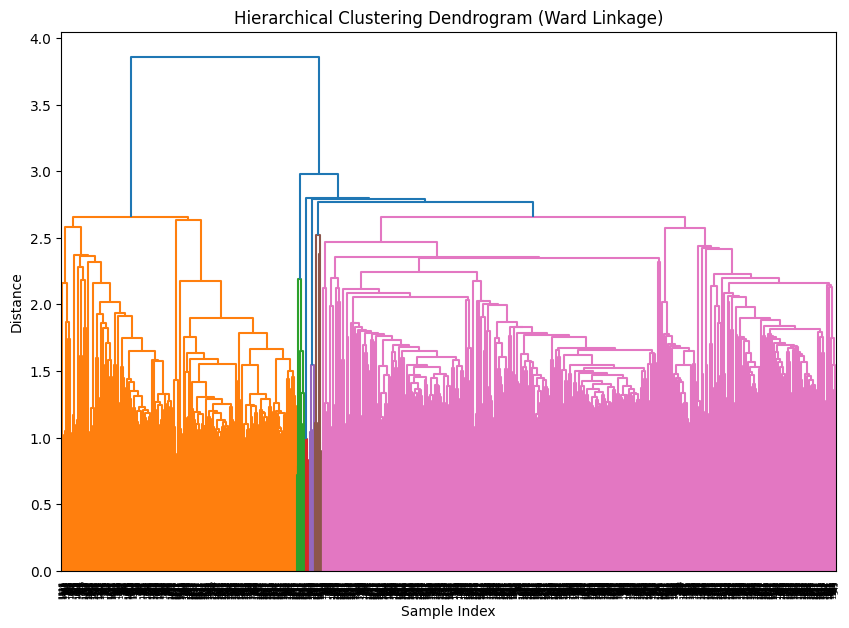

In [140]:
#Visualize Using Dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(X.toarray(), method='ward')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()